### Modelo clásico (SVM) con HOG

### IMPORT LIBRARIES

In [16]:
import os, io, random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from collections import Counter
import pathlib, shutil
from sklearn.metrics import classification_report, confusion_matrix

### LOAD DATA

In [24]:
base_dir= "skin-lesions"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

BALANCEO DE CLASES ELIMINANDO IMAGENES DE LA CLASE MAYORITARIA (YA EXPLICADO EN EL EDA)

In [25]:
ROOT = pathlib.Path("skin-lesions/train")  
KEEP_RATIO = 1.0                   

melanoma_dir   = ROOT / "melanoma"
nevus_dir      = ROOT / "nevus"
discarded_dir  = nevus_dir.parent / "_discarded"
discarded_dir.mkdir(exist_ok=True)

n_melanoma = len(list(melanoma_dir.glob("*")))
nevus_imgs = sorted(nevus_dir.glob("*"))                # orden fijo
max_nevus  = int(n_melanoma * KEEP_RATIO)
keep_nevus = nevus_imgs[:max_nevus]                     # mismas siempre
drop_nevus = nevus_imgs[max_nevus:]


for img in drop_nevus:
    shutil.move(str(img), discarded_dir / img.name)     # usa os.remove() para borrar

print(f"Conservadas {len(keep_nevus)} imágenes de nevus.")
print(f"Descartadas {len(drop_nevus)} → {discarded_dir}")

# Guardar la lista para control de versiones
with open("nevus_kept.txt", "w", encoding="utf-8") as f:
    f.writelines(f"{p.name}\n" for p in keep_nevus)
print("Lista de imágenes conservadas guardada en nevus_kept.txt")


Conservadas 374 imágenes de nevus.
Descartadas 0 → skin-lesions/train/_discarded
Lista de imágenes conservadas guardada en nevus_kept.txt


### FEATURE EXTRACTION

Se procesan todas las imágenes del conjunto de entrenamiento para construir un vector de características por imagen. 
Se combinan tres tipos de información:

Forma: usando HOG (Histogram of Oriented Gradients) sobre una versión en escala de grises de la imagen.

Color: media y desviación típica de los canales R, G y B.

Textura: entropía de Shannon como medida global de complejidad.

Cada imagen queda representada por un único vector numérico que resume su estructura, color y textura. Estos vectores se usarán como entrada para los modelos clásicos de clasificación.

In [ ]:
IMG_SIZE = (224, 224)  
label_map = {cls: idx for idx, cls in enumerate(classes)}

from skimage.measure import shannon_entropy

X = []
y = []
img_paths = []

for cls in classes:
    class_dir = os.path.join("skin-lesions/train", cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img_paths.append(img_path)
        label = label_map[cls]
        y.append(label)

        # Leer imagen RGB
        img = imread(img_path)
        img_resized = cv2.resize(img, (224, 224))

        # Extraer HOG de escala de grises
        if img_resized.ndim == 3:
            gray = rgb2gray(img_resized)
        else:
            gray = img_resized
        hog_feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)

        # Color: media y std de cada canal RGB
        if img_resized.ndim == 3:
            r_mean, g_mean, b_mean = np.mean(img_resized, axis=(0, 1))
            r_std, g_std, b_std = np.std(img_resized, axis=(0, 1))
        else:
            r_mean = g_mean = b_mean = np.mean(img_resized)
            r_std = g_std = b_std = np.std(img_resized)

        # Textura: entropía
        entropy = shannon_entropy(gray)

        # Concatenar todo en un único vector
        extra_features = [r_mean, g_mean, b_mean, r_std, g_std, b_std, entropy]
        full_features = np.concatenate([hog_feat, extra_features])
        X.append(full_features)

X = np.array(X)
y = np.array(y)

### ENTRENO DEL MODELO DE ML

Se divide el conjunto de datos en entrenamiento y test conservando la proporción de clases (stratify=y). A continuación, se entrena un clasificador SVM con kernel lineal sobre los vectores de características manuales (HOG + color + textura). Finalmente, se evalúa el rendimiento sobre el conjunto de test mediante métricas estándar como precisión, recall y F1-score para cada clase. También se genera la matriz de confusión para analizar visualmente qué clases tienden a confundirse. Cada celda muestra el número de imágenes clasificadas en cada combinación de predicción y etiqueta real. Esta representación permite detectar patrones de error, como confusiones frecuentes entre nevus y melanoma.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear')  # puedes probar también 'rbf' o usar GridSearchCV
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=classes))

                      precision    recall  f1-score   support

            melanoma       0.57      0.60      0.58        75
seborrheic_keratosis       0.74      0.67      0.70        51
               nevus       0.72      0.73      0.73        75

            accuracy                           0.67       201
           macro avg       0.68      0.67      0.67       201
        weighted avg       0.67      0.67      0.67       201



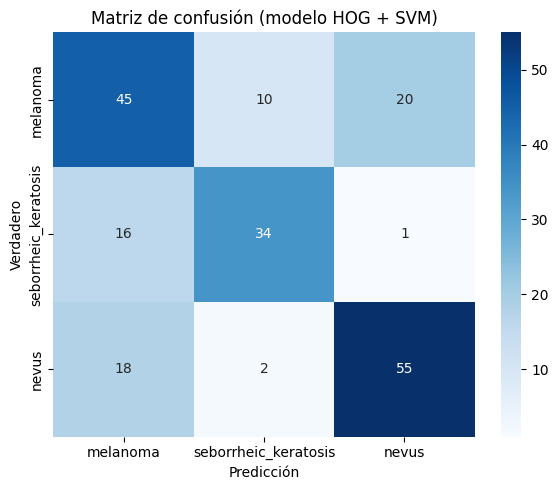

In [29]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Matriz de confusión (modelo HOG + SVM)")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

### RESULTADOS DEL MODELO

El clasificador SVM entrenado sobre las características manuales (HOG + color + textura) obtiene un accuracy del 67 %, con un rendimiento equilibrado entre clases.

La clase “nevus” es la mejor reconocida (F1 = 0.73), seguida de seborrheic keratosis (F1 = 0.70).
La clase “melanoma” obtiene un F1 de 0.58, aceptable pero con margen de mejora.

La matriz de confusión muestra que los errores más frecuentes se dan al confundir melanomas con nevus, lo cual es clínicamente significativo y refleja la dificultad de diferenciar visualmente entre estas dos clases.